# Merging Positive and Negative Samples and Normalizing the Data

We will merge the positive and negative samples into a single dataset and normalize the features for consistent scaling. This ensures the data is ready for analysis or machine learning.



Download the CSV files here:
[Positive and Negative Samples](https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1zut7nFz_dJoHZiLcYi_fBrOEQLlWpxjJ%3Fusp%3Dsharing)

In [13]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the CSV files
positive_df = pd.read_csv('/content/processed_data.csv')
negative_df = pd.read_csv('/content/negative_samples_final.csv')

# Add the OvertakeHappened column
positive_df['OvertakeHappened'] = 1
negative_df['OvertakeHappened'] = 0

# Merge the two dataframes
merged_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Drop the 'OvertakerDrsState' column
if 'OvertakerDrsState' in merged_df.columns:
    merged_df = merged_df.drop(columns=['OvertakerDrsState'])

# Take absolute value of 'SpeedDelta'
merged_df['SpeedDelta'] = merged_df['SpeedDelta'].abs()

scaler = StandardScaler()
columns_to_normalize = ['AverageCornerSpeed', 'DistanceDelta', 'SpeedDelta']

# Ensure the columns exist
for col in columns_to_normalize:
    if col not in merged_df.columns:
        raise ValueError(f"Column {col} not found in the data.")

merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])
merged_df.drop('AvoidTurn', axis=1, inplace=True)

# Save the result to a new CSV file
merged_df.to_csv('merged_normalized_data.csv', index=False)

print("Merging and processing complete! Output saved to 'merged_normalized_data.csv'.")


Merging and processing complete! Output saved to 'merged_normalized_data.csv'.


# Understanding the Structure of Data

The goal is to assess if the samples are separable in their current form and determine if additional features are needed. We will use techniques like PCA, LDA, and t-SNE for dimensionality reduction and visualization.

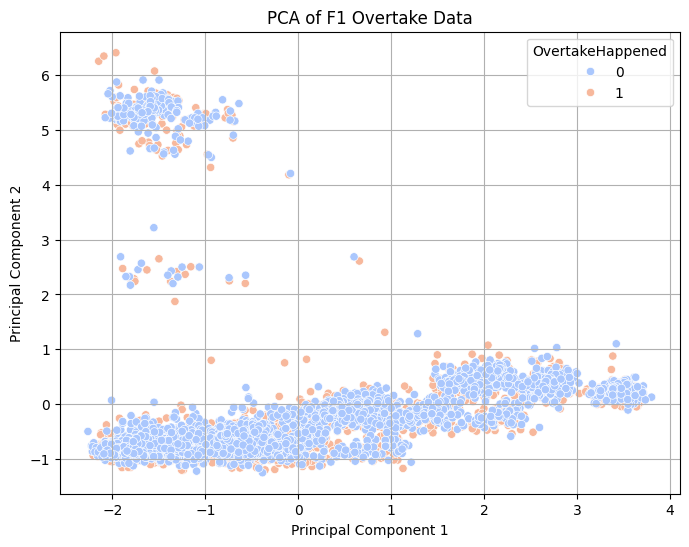

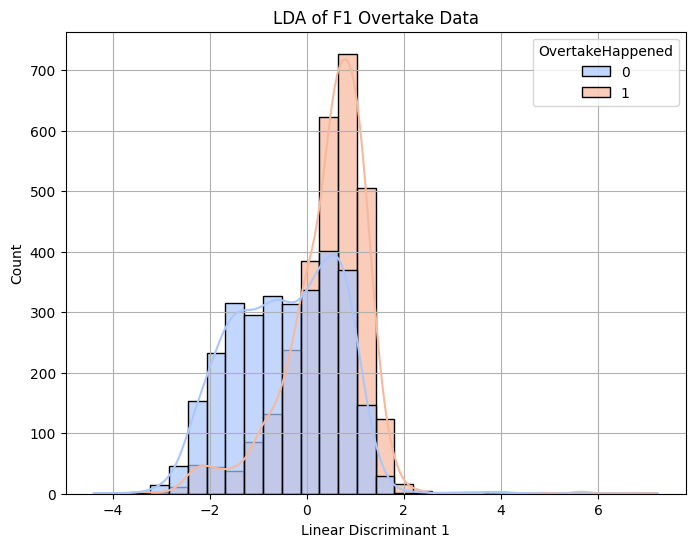

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


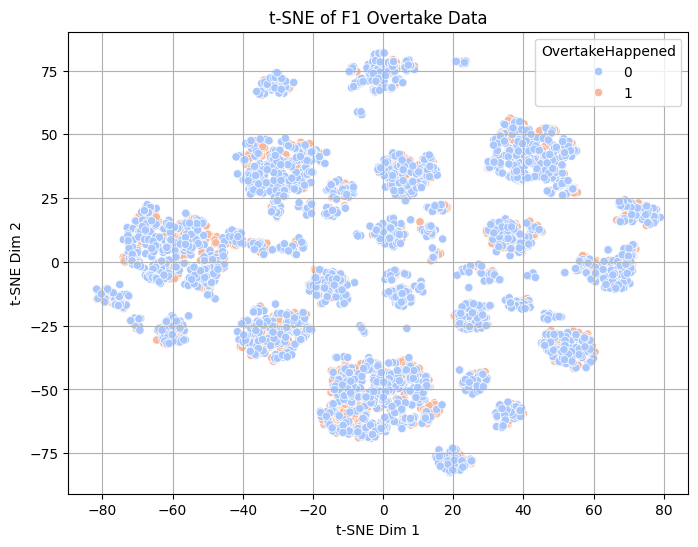

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Load your data
df = pd.read_csv('merged_normalized_data.csv')

# Drop categorical/string columns (or encode them if needed)
drop_cols = ['Race', 'Overtaker', 'Overtaken', 'Turn', 'Session', 'Lap', 'Position', 'Year', 'OvertakerNumber', 'OvertakenNumber', 'X', 'Y']

df = df.drop(columns=drop_cols)


# Fill NaNs
df = df.fillna(0)

# Separate features and target
y = df['OvertakeHappened']
X = df.drop(columns=['OvertakeHappened'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# PCA
# ==========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm')
plt.title('PCA of F1 Overtake Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# ==========================
# LDA
# ==========================
lda = LDA(n_components=1)  # For binary classification
X_lda = lda.fit_transform(X_scaled, y)

plt.figure(figsize=(8,6))
sns.histplot(x=X_lda[:,0], hue=y, bins=30, kde=True, palette='coolwarm', alpha=0.7)
plt.title('LDA of F1 Overtake Data')
plt.xlabel('Linear Discriminant 1')
plt.grid(True)
plt.show()

# ==========================
# t-SNE
# ==========================
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='coolwarm')
plt.title('t-SNE of F1 Overtake Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True)
plt.show()


# Observations
* The classes show some separability but have significant overlap.

* The classes are not fully isolated.

# Building and Evaluating Predictive Models

We will build and evaluate predictive models using Random Forest, XGBoost, and MLP to assess their performance on the data.

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:11:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.80      0.73      0.76       600
           1       0.75      0.81      0.78       599

    accuracy                           0.77      1199
   macro avg       0.77      0.77      0.77      1199
weighted avg       0.77      0.77      0.77      1199



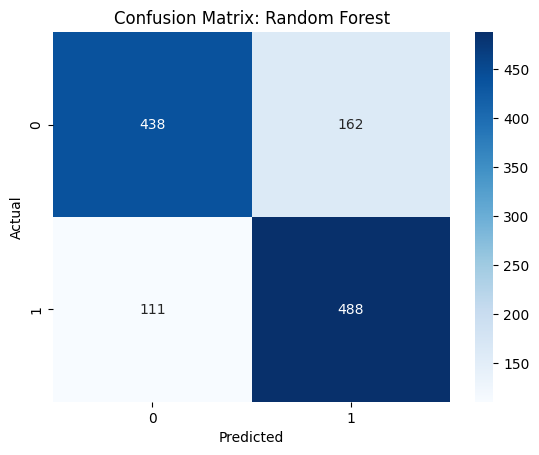

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       600
           1       0.78      0.81      0.80       599

    accuracy                           0.79      1199
   macro avg       0.79      0.79      0.79      1199
weighted avg       0.79      0.79      0.79      1199



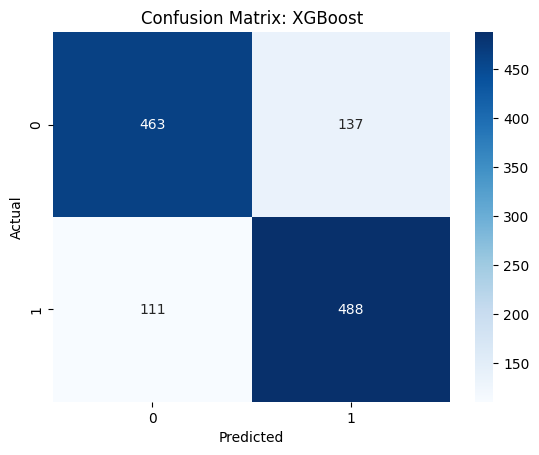

--- MLP ---
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       600
           1       0.68      0.67      0.68       599

    accuracy                           0.68      1199
   macro avg       0.68      0.68      0.68      1199
weighted avg       0.68      0.68      0.68      1199



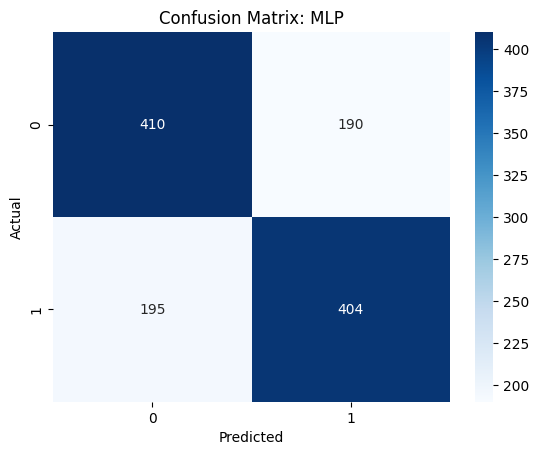

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("merged_normalized_data.csv")

# Drop non-numeric or irrelevant columns
drop_cols = ['Race', 'Overtaker', 'Overtaken', 'Turn', 'Session', 'Lap', 'Position', 'Year', 'OvertakerNumber', 'OvertakenNumber', 'X', 'Y']

df = df.drop(columns=drop_cols)

# Drop NaNs
df = df.dropna()

# Split features and target
X = df.drop("OvertakeHappened", axis=1)
y = df["OvertakeHappened"]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 1. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 2. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 3. MLP (Neural Net)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate all models
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("MLP", y_test, y_pred_mlp)


# Data Preprocessing and Model Evaluation (Without Absolute SpeedDelta)

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the CSV files
positive_df = pd.read_csv('/content/processed_data.csv')
negative_df = pd.read_csv('/content/negative_samples_final.csv')

# Compare Turn values row by row and modify SpeedDelta in negative_df
negative_df['SpeedDelta'] = [
    -sd if n_turn > p_turn else sd
    for sd, n_turn, p_turn in zip(
        negative_df['SpeedDelta'],
        negative_df['Turn'],
        positive_df['Turn']
    )
]

# Add the OvertakeHappened column
positive_df['OvertakeHappened'] = 1
negative_df['OvertakeHappened'] = 0

# Merge the two dataframes
merged_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Drop the 'OvertakerDrsState' column
if 'OvertakerDrsState' in merged_df.columns:
    merged_df = merged_df.drop(columns=['OvertakerDrsState'])

# Normalize specific columns
scaler = StandardScaler()
columns_to_normalize = ['AverageCornerSpeed', 'DistanceDelta', 'SpeedDelta']

# Ensure the columns exist
for col in columns_to_normalize:
    if col not in merged_df.columns:
        raise ValueError(f"Column {col} not found in the data.")

merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])
merged_df.drop('AvoidTurn', axis=1, inplace=True)

# Save the result to a new CSV file
merged_df.to_csv('merged_data.csv', index=False)

print("Merging and processing complete! Output saved to 'merged_normalized_data.csv'.")


Merging and processing complete! Output saved to 'merged_normalized_data.csv'.


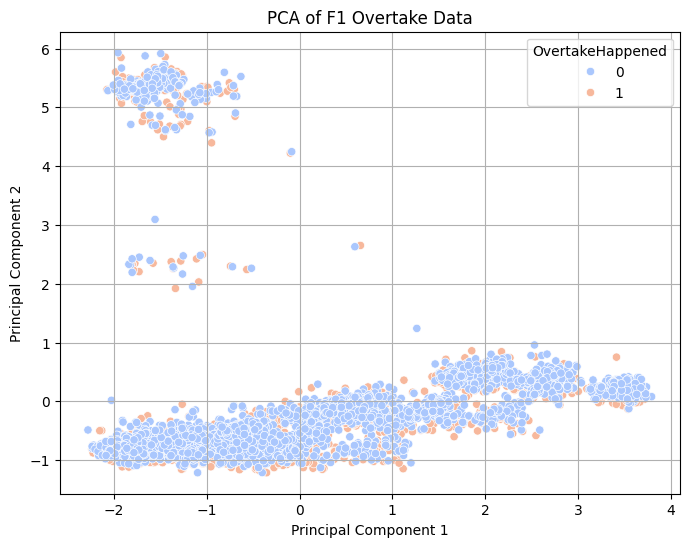

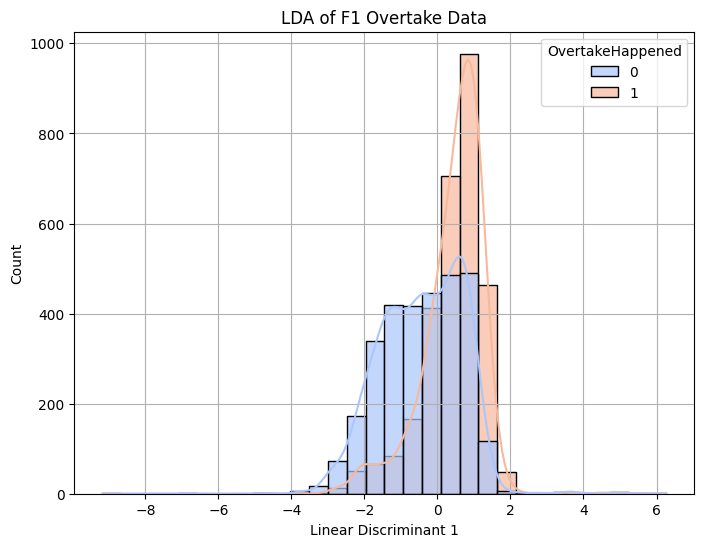

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


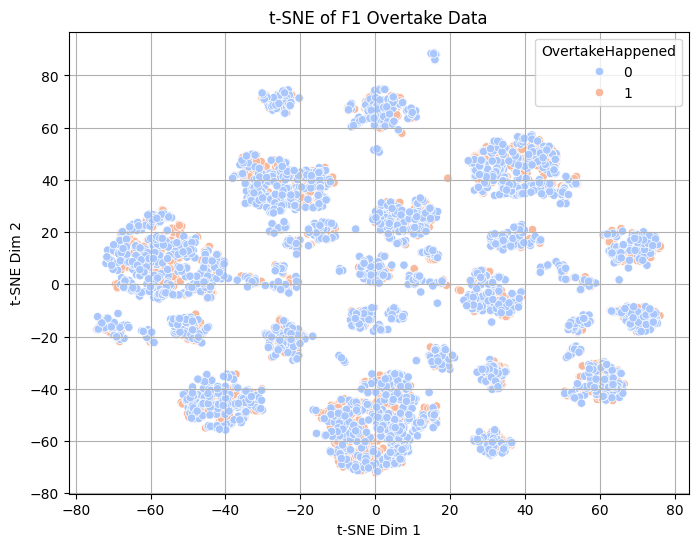

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Load your data
df = pd.read_csv('merged_data.csv')

# Drop categorical/string columns
drop_cols = ['Race', 'Overtaker', 'Overtaken', 'Turn', 'Session', 'Lap', 'Position', 'Year', 'OvertakerNumber', 'OvertakenNumber', 'X', 'Y']

df = df.drop(columns=drop_cols)

# Fill NaNs
df = df.fillna(0)

# Separate features and target
y = df['OvertakeHappened']
X = df.drop(columns=['OvertakeHappened'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# PCA
# ==========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm')
plt.title('PCA of F1 Overtake Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# ==========================
# LDA
# ==========================
lda = LDA(n_components=1)  # For binary classification
X_lda = lda.fit_transform(X_scaled, y)

plt.figure(figsize=(8,6))
sns.histplot(x=X_lda[:,0], hue=y, bins=30, kde=True, palette='coolwarm', alpha=0.7)
plt.title('LDA of F1 Overtake Data')
plt.xlabel('Linear Discriminant 1')
plt.grid(True)
plt.show()

# ==========================
# t-SNE
# ==========================
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='coolwarm')
plt.title('t-SNE of F1 Overtake Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:13:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       600
           1       0.76      0.82      0.79       599

    accuracy                           0.78      1199
   macro avg       0.78      0.78      0.78      1199
weighted avg       0.78      0.78      0.78      1199



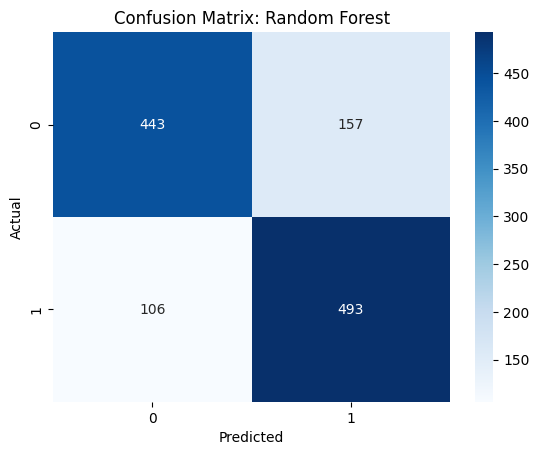

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       600
           1       0.79      0.83      0.81       599

    accuracy                           0.81      1199
   macro avg       0.81      0.81      0.81      1199
weighted avg       0.81      0.81      0.81      1199



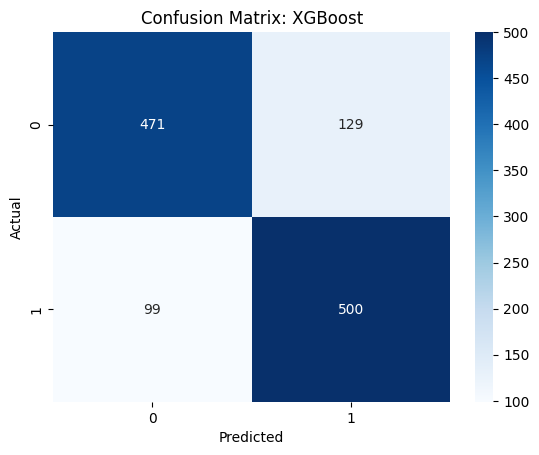

--- MLP ---
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       600
           1       0.69      0.77      0.73       599

    accuracy                           0.71      1199
   macro avg       0.72      0.71      0.71      1199
weighted avg       0.72      0.71      0.71      1199



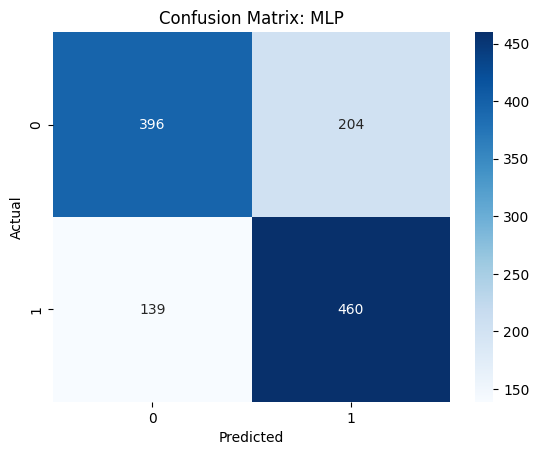

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("merged_data.csv")

# Drop non-numeric or irrelevant columns
drop_cols = ['Race', 'Overtaker', 'Overtaken', 'Turn', 'Session', 'Lap', 'Position', 'Year', 'OvertakerNumber', 'OvertakenNumber', 'X', 'Y']

df = df.drop(columns=drop_cols)

# Drop NaNs (or handle them appropriately)
df = df.dropna()

# Split features and target
X = df.drop("OvertakeHappened", axis=1)
y = df["OvertakeHappened"]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 1. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 2. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 3. MLP (Neural Net)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate all models
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("MLP", y_test, y_pred_mlp)


# Data Preprocessing and Model Evaluation (With Double Negative Samples)

In [28]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the CSV files
positive_df = pd.read_csv('/content/processed_data.csv')
negative_df = pd.read_csv('/content/negative_samples_final2.csv')

# Add the OvertakeHappened column
positive_df['OvertakeHappened'] = 1
negative_df['OvertakeHappened'] = 0

# Merge the two dataframes
merged_df = pd.concat([positive_df, negative_df], ignore_index=True)

# Drop the 'OvertakerDrsState' column
if 'OvertakerDrsState' in merged_df.columns:
    merged_df = merged_df.drop(columns=['OvertakerDrsState'])

# Take absolute value of 'SpeedDelta'
merged_df['SpeedDelta'] = merged_df['SpeedDelta'].abs()

scaler = StandardScaler()
columns_to_normalize = ['AverageCornerSpeed', 'DistanceDelta', 'SpeedDelta']



# Ensure the columns exist
for col in columns_to_normalize:
    if col not in merged_df.columns:
        raise ValueError(f"Column {col} not found in the data.")

merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])


# Save the result to a new CSV file
merged_df.to_csv('merged_normalized_data.csv', index=False)

print("Merging and processing complete! Output saved to 'merged_normalized_data.csv'.")


Merging and processing complete! Output saved to 'merged_normalized_data.csv'.


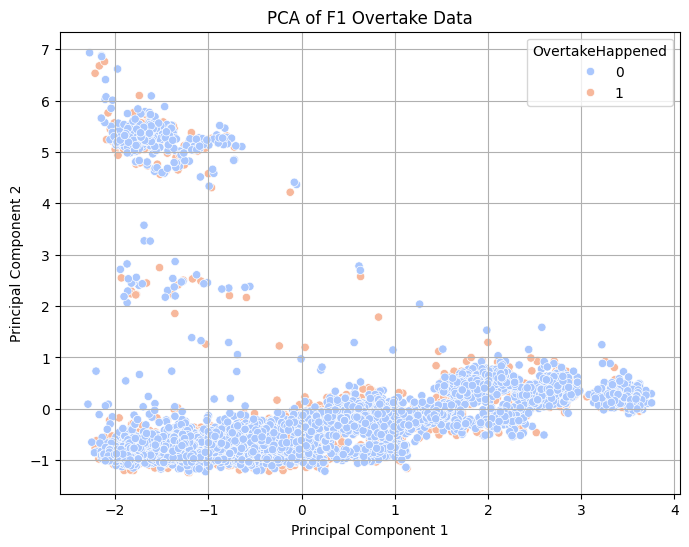

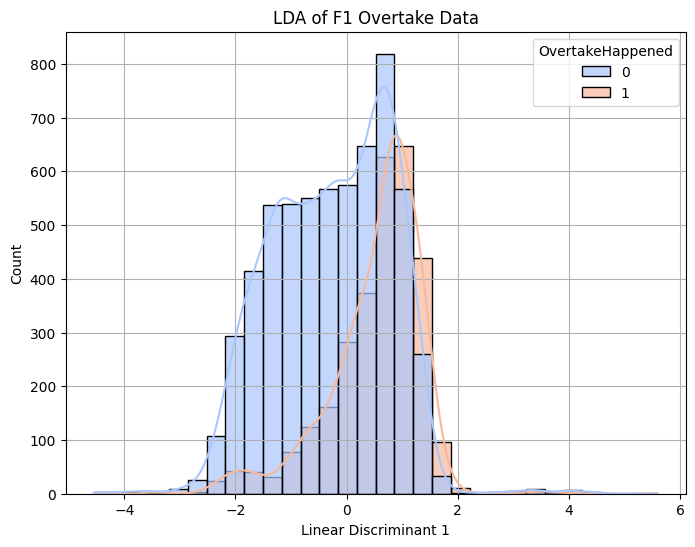

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


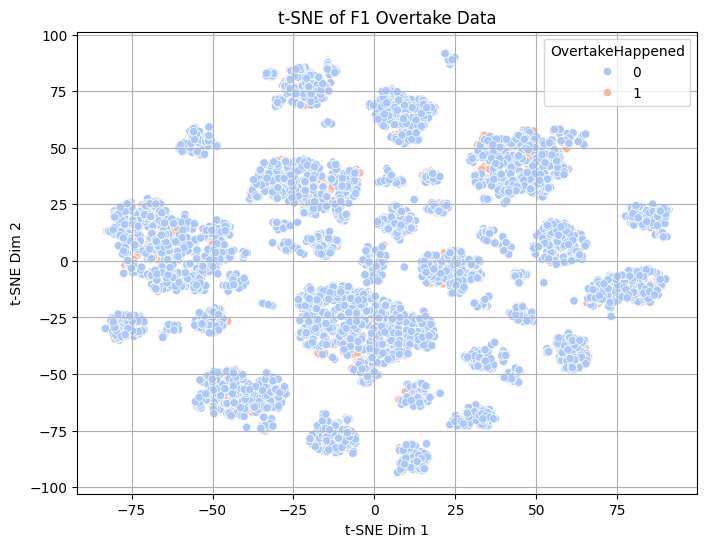

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

# Load your data
df = pd.read_csv('merged_normalized_data.csv')

# Drop categorical/string columns
drop_cols = ['Race', 'Overtaker', 'Overtaken', 'Turn', 'Session', 'Lap', 'Position', 'Year', 'OvertakerNumber', 'OvertakenNumber', 'X', 'Y']

df = df.drop(columns=drop_cols)

# Fill NaNs
df = df.fillna(0)

# Separate features and target
y = df['OvertakeHappened']
X = df.drop(columns=['OvertakeHappened'])

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# PCA
# ==========================
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='coolwarm')
plt.title('PCA of F1 Overtake Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# ==========================
# LDA
# ==========================
lda = LDA(n_components=1)  # For binary classification
X_lda = lda.fit_transform(X_scaled, y)

plt.figure(figsize=(8,6))
sns.histplot(x=X_lda[:,0], hue=y, bins=30, kde=True, palette='coolwarm', alpha=0.7)
plt.title('LDA of F1 Overtake Data')
plt.xlabel('Linear Discriminant 1')
plt.grid(True)
plt.show()

# ==========================
# t-SNE
# ==========================
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='coolwarm')
plt.title('t-SNE of F1 Overtake Data')
plt.xlabel('t-SNE Dim 1')
plt.ylabel('t-SNE Dim 2')
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:17:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      1199
           1       0.74      0.69      0.71       600

    accuracy                           0.81      1799
   macro avg       0.79      0.78      0.79      1799
weighted avg       0.81      0.81      0.81      1799



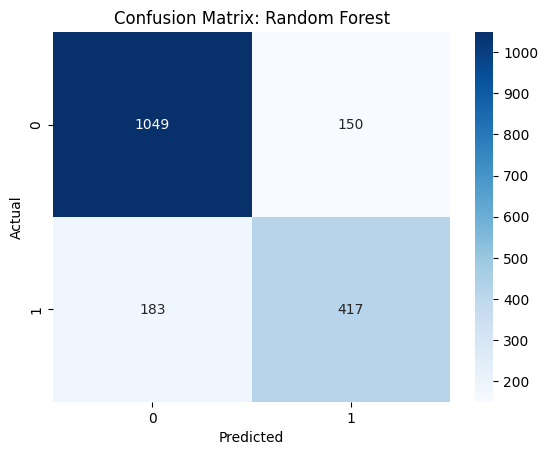

--- XGBoost ---
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      1199
           1       0.78      0.75      0.76       600

    accuracy                           0.84      1799
   macro avg       0.83      0.82      0.82      1799
weighted avg       0.84      0.84      0.84      1799



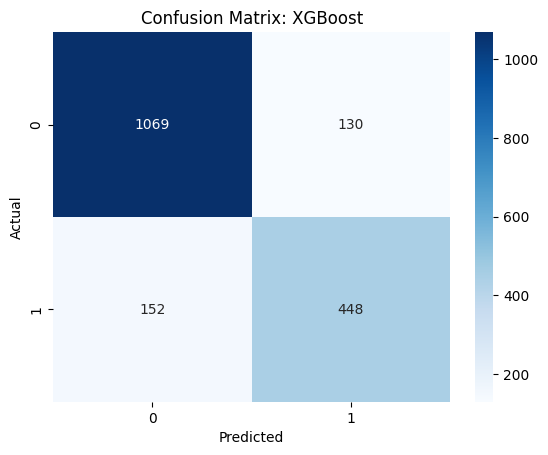

--- MLP ---
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      1199
           1       0.59      0.66      0.62       600

    accuracy                           0.73      1799
   macro avg       0.70      0.71      0.71      1799
weighted avg       0.74      0.73      0.74      1799



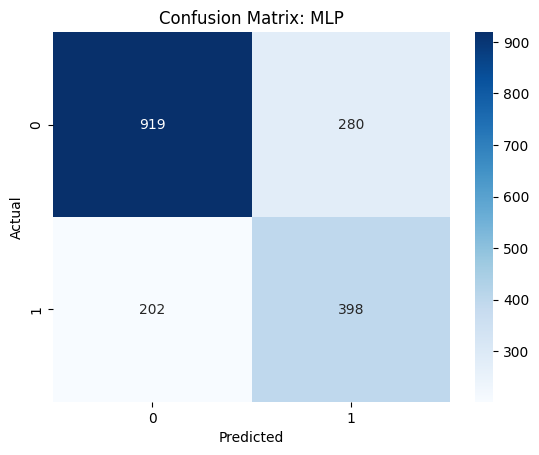

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("merged_normalized_data.csv")

# Drop non-numeric or irrelevant columns
drop_cols = ['Race', 'Overtaker', 'Overtaken', 'Turn', 'Session', 'Lap', 'Position', 'Year', 'OvertakerNumber', 'OvertakenNumber', 'X', 'Y']

df = df.drop(columns=drop_cols)

# Drop NaNs (or handle them appropriately)
df = df.dropna()

# Split features and target
X = df.drop("OvertakeHappened", axis=1)
y = df["OvertakeHappened"]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 1. Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 2. XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

# 3. MLP (Neural Net)
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Evaluate all models
evaluate_model("Random Forest", y_test, y_pred_rf)
evaluate_model("XGBoost", y_test, y_pred_xgb)
evaluate_model("MLP", y_test, y_pred_mlp)
